In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import os

In [ ]:
from local.torch_basics import *
from local.test import *
from local.basics import *
from local.data.all import *
from local.vision.core import *
from local.notebook.showdoc import show_doc
from local.audio.core import *
from local.audio.augment import *
from local.vision.learner import *
from local.vision.models.xresnet import *
from local.metrics import *
from local.callback.schedule import *
import torchaudio
from IPython.display import Audio, display

# Tutorial: Training a Voice Recognition Model

In [ ]:
import zipfile

In [ ]:
from pyunpack import Archive

In [ ]:
p10speakers = Config()['data_path'] / 'ST-AEDS-20180100_1-OS'

In [ ]:
#def arc_extract(fname, dest): Archive(fname).extractall(dest)
URLs.ESC50 = 'https://github.com/karoldvl/ESC-50/archive/master.zip'
pESC50 = Config()['data_path'] / 'ESC-50/ESC-50-master'
#untar_data(URLs.ESC50, fname=str(pESC50)+'.zip', dest=pESC50, extract_func=arc_extract)

In [ ]:
#Warning this dataset is ~8GB
p250speakers = Config()['data_path'] / '250_speakers'
untar_data(URLs.SPEAKERS250, fname=str(p250speakers)+'.tar', dest=p250speakers)

PosixPath('/home/jupyter/.fastai/data/250_speakers/250-speakers')

In [ ]:
x = AudioGetter("", recurse=True, folders=None)
files_10  = x(p10speakers)
files_250 = x(p250speakers)
files_ESC50 = x(pESC50)
#original_aud = AudioItem.create(files[0])

## Datablock and Basic End to End Training on 10 Speakers

In [ ]:
def AudioBlock(cls=AudioItem): return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor)

In [ ]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 get_y=lambda x: str(x).split('/')[-1][:5])

In [ ]:
cats = [y for _,y in auds.datasource(p10speakers)]

In [ ]:
#verify categories are being correctly assigned
test_eq(min(cats).item(), 0)
test_eq(max(cats).item(), 9)

In [ ]:
#crop 2s from the signal and turn it to a MelSpectrogram with no augmentation
cfg_voice = AudioConfig.Voice()
a2s = AudioToSpec.from_cfg(cfg_voice)
crop_2000ms = CropSignal(2000)
tfms = [crop_2000ms, a2s]
dbunch = auds.databunch(p10speakers, item_tfms=tfms, bs=64)

<div class = "alert alert-block alert-warning"><strong>Broken:</strong><br>Show batch is broken as it appears to just be grabbing the data from the sg, and not the sg object itself, but calls the sg's show method which relies on nchannels, which is an object of AudioSpectrogram (part of sg settings but we overrode getattr to make it work like an attribute). This means that, for the moment, the items cant show themselves for the batch, but training still works </div>


In [ ]:
#dbunch_cropspec.show_batch(max_n=9)

In [ ]:
dbunch.one_batch()[0].shape

torch.Size([64, 1, 128, 251])

In [ ]:
# credit to Kevin Bird and Hiromi Suenaga for these two lines to adjust a CNN model to take 1 channel input
def alter_learner(learn, channels=1):
    learn.model[0][0].in_channels=channels
    learn.model[0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0].weight[:,1,:,:].unsqueeze(1))

In [ ]:
learn = Learner(dbunch, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
nchannels = dbunch.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

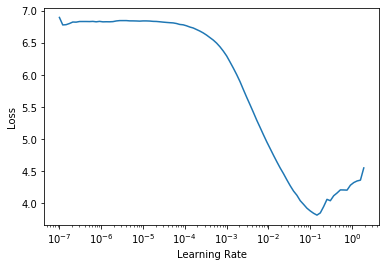

In [ ]:
learn.lr_find()

In [ ]:
#epochs are a bit longer due to the chosen melspectrogram settings
learn.fit_one_cycle(10, lr_max=slice(1e-2))

(#5) [0,1.9626456499099731,1.358862280845642,0.49609375,00:12]
(#5) [1,0.7889631390571594,8.353211402893066,0.1731770783662796,00:11]
(#5) [2,0.4145869016647339,3.036802053451538,0.5794270634651184,00:11]
(#5) [3,0.2525951862335205,1.6720212697982788,0.6875,00:11]
(#5) [4,0.15228423476219177,0.7339551448822021,0.83203125,00:11]
(#5) [5,0.1163148358464241,2.678802728652954,0.6119791865348816,00:11]
(#5) [6,0.0719689130783081,0.062158506363630295,0.9765625,00:11]
(#5) [7,0.0451962873339653,0.03220104053616524,0.9908854365348816,00:11]
(#5) [8,0.032597947865724564,0.0297225508838892,0.98828125,00:12]
(#5) [9,0.021791895851492882,0.02578715980052948,0.9908854365348816,00:12]


# Training on 250 Speakers

## Baseline

In [ ]:
len(files_250)

44655

In [ ]:
for i in range(10):
    print(random.choice(files_250))

/home/jupyter/.fastai/data/250_speakers/250-speakers/id08910/c9SrHQ6iSiU/00054.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id08923/BIN2PeoN6gg/00026.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id08996/liBbfkvpKhw/00045.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id09186/FPuVhMfYsj4/00066.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id08879/CmtWhHaP7U8/00006.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id08997/bWtRLJQ7QGM/00073.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id09236/LlTIdY92nmI/00013.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id09057/FL4xjnaF8Ks/00007.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id08999/QeAZmOwYKNo/00218.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id08928/9ZgPk5LHRug/00024.wav


In [ ]:
get_250speakers_label = lambda x: str(x).split('/')[-3][3:]

In [ ]:
for i in range(10):
    f = random.choice(files_250)
    print("File:",f )
    print("Label:", get_250speakers_label(f))

File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id09059/26r_bBrRxOk/00001.wav
Label: 9059
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id09071/MNKyAthzGfI/00153.wav
Label: 9071
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id09021/GiTLl9w5Qdw/00023.wav
Label: 9021
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id09088/mF-E0LSdRlQ/00394.wav
Label: 9088
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id09235/eKuL9vNb7Oo/00146.wav
Label: 9235
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id09186/dCm42DSaYEk/00425.wav
Label: 9186
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id09034/fc69z5YvdZA/00169.wav
Label: 9034
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id09192/l-ft4fQ7M7k/00243.wav
Label: 9192
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id08944/awbtRYb1bS8/00085.wav
Label: 8944
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id09237/Nudby-bnL2U/00084.wav
La

In [ ]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 get_y=get_250speakers_label)

In [ ]:
dbunch250 = auds.databunch(p250speakers, item_tfms=tfms, bs=64)

In [ ]:
from fastprogress import progress_bar as pb

In [ ]:
cats = [y for _,y in pb(auds.datasource(p250speakers))]

In [ ]:
#verify categories are being correctly assigned for 250 speakers
test_eq(min(cats).item(), 0)
test_eq(max(cats).item(), 249)

In [ ]:
# Use torchaudio default MelSpectrogram to get a baseline
a2s = AudioToSpec()
crop_4000ms = CropSignal(4000)
tfms = [crop_4000ms, a2s]
dbunch = auds.databunch(p250speakers, item_tfms=tfms, bs=256)

In [ ]:
learn = Learner(dbunch, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
nchannels = dbunch.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

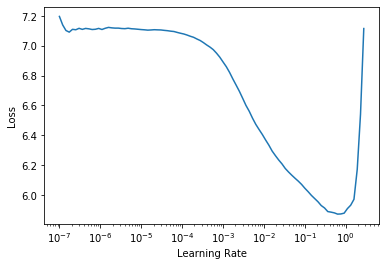

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, lr_max=slice(2e-2))

(#5) [0,3.2122292518615723,4.0813679695129395,0.23759937286376953,01:04]
(#5) [1,1.316498875617981,1.6841962337493896,0.6065390110015869,01:04]
(#5) [2,0.647162914276123,0.7752794027328491,0.8013660311698914,01:04]
(#5) [3,0.2630617022514343,0.40967297554016113,0.8973239064216614,01:04]
(#5) [4,0.10401999950408936,0.30818530917167664,0.9249804019927979,01:04]


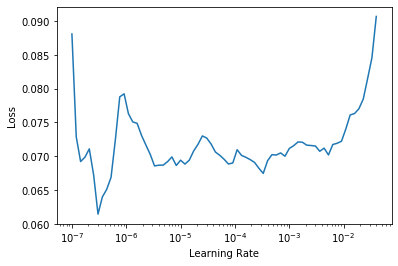

In [ ]:
learn.lr_find()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, lr_max=slice(1e-3))

(#5) [0,0.06768660247325897,0.3031019866466522,0.9256522059440613,01:04]
(#5) [1,0.06981414556503296,0.31619778275489807,0.9208375215530396,01:04]
(#5) [2,0.04986869916319847,0.28395724296569824,0.9330422282218933,01:04]
(#5) [3,0.0395052470266819,0.2880662977695465,0.9318105578422546,01:04]
(#5) [4,0.03327617421746254,0.2784707844257355,0.9357295036315918,01:04]


## Customize our AudioToSpec Function using a config

In [ ]:
voice_cfg = AudioConfig.Voice()
a2s = AudioToSpec.from_cfg(voice_cfg)
tfms = [crop_4000ms, a2s]
# tfms = Pipeline([CropSignal(4000),  a2s, MaskFreq(size=12), MaskTime(size=15), SGRoll()], as_item=True)
dbunch = auds.databunch(p250speakers, item_tfms=tfms, bs=128)

In [ ]:
learn = Learner(dbunch, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
nchannels = dbunch.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

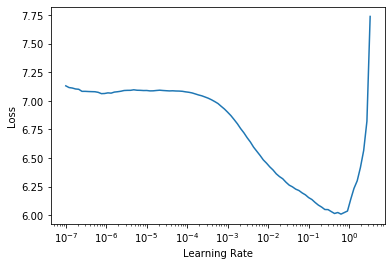

In [ ]:
learn.lr_find()

In [ ]:
# Better results even without fine tuning, but much slower. We need to move a2s to the GPU and 
# then add data augmentation!
learn.fit_one_cycle(5, lr_max=slice(2e-2))

(#5) [0,2.370701789855957,4.801907539367676,0.21027880907058716,03:55]
(#5) [1,0.9351741075515747,1.4241888523101807,0.6497592926025391,03:53]
(#5) [2,0.4317864775657654,0.6161158680915833,0.83988356590271,03:53]
(#5) [3,0.1602507382631302,0.311890572309494,0.9218452572822571,03:53]
(#5) [4,0.052644867449998856,0.22105051577091217,0.9510692954063416,03:53]


## Training an MFCC with Delta

In [ ]:
# only grab 1500ms of the clip, voice identity can be done with shorter sections and it will speed it up
# this is really slow for mfcc, even for 45k files, need to figure out what's going on here. Also the results
# shouldn't be this much worse than melspectrogram
a2mfcc = AudioToMFCC(n_mffc=20, melkwargs={"n_fft":2048, "hop_length":256, "n_mels":128})
tfms = [CropSignal(1500), a2mfcc, Delta()]
# tfms = Pipeline([CropSignal(4000),  a2s, MaskFreq(size=12), MaskTime(size=15), SGRoll()], as_item=True)
dbunch = auds.databunch(p250speakers, item_tfms=tfms, bs=1024)

In [ ]:
#n_mfcc isn't getting passed down? 
dbunch.one_batch()[0].shape

torch.Size([1024, 3, 40, 94])

In [ ]:
learn = Learner(dbunch, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])

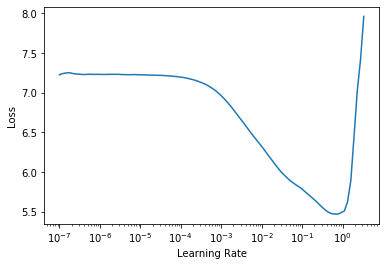

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(2e-2))

(#5) [0,4.666947841644287,4.712531089782715,0.09965289384126663,01:18]
(#5) [1,3.334801435470581,12.688240051269531,0.034710559993982315,01:13]
(#5) [2,2.457864284515381,4.543926239013672,0.20949502289295197,01:14]
(#5) [3,1.827263593673706,2.5221168994903564,0.43746501207351685,01:13]
(#5) [4,1.376752257347107,1.7172975540161133,0.585600733757019,01:14]
(#5) [5,1.0380667448043823,1.3251761198043823,0.6712574362754822,01:13]
(#5) [6,0.7777164578437805,1.0692423582077026,0.7374314069747925,01:13]
(#5) [7,0.5751940011978149,0.6517168283462524,0.8404433727264404,01:14]
(#5) [8,0.4284226894378662,0.5516476631164551,0.8659724593162537,01:13]
(#5) [9,0.3302121162414551,0.5454989075660706,0.8688836693763733,01:13]


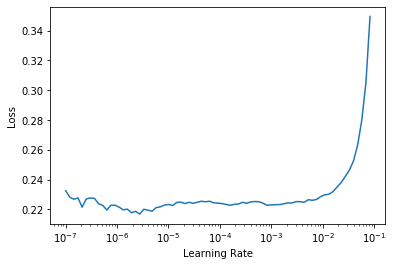

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(7, lr_max=slice(3e-3, 4e-3))

(#5) [0,0.22381065785884857,0.5382125973701477,0.8697794079780579,01:13]
(#5) [1,0.23459886014461517,0.739894449710846,0.8196170926094055,01:13]
(#5) [2,0.2472066879272461,0.601187527179718,0.8538797497749329,01:12]
(#5) [3,0.22701896727085114,0.5553048849105835,0.8654125928878784,01:13]
(#5) [4,0.19371949136257172,None,None,01:05]


KeyboardInterrupt: 

<div class='alert alert-block alert-info'><strong>From Here:</strong><br>
    1. Get transforms on the GPU <br>
    2. Once it's faster test signal and spectrogram augments for speed/efficacy<br>
    3. Fine-tune and see how high we can push results on 250 speakers
</div>


# ESC-50

In [ ]:
files_ESC50

(#2000) [/home/jupyter/.fastai/data/ESC-50/ESC-50-master/audio/1-60676-A-34.wav,/home/jupyter/.fastai/data/ESC-50/ESC-50-master/audio/5-179865-A-43.wav,/home/jupyter/.fastai/data/ESC-50/ESC-50-master/audio/2-117271-A-0.wav,/home/jupyter/.fastai/data/ESC-50/ESC-50-master/audio/1-155858-B-25.wav,/home/jupyter/.fastai/data/ESC-50/ESC-50-master/audio/4-173865-B-9.wav,/home/jupyter/.fastai/data/ESC-50/ESC-50-master/audio/2-104877-A-3.wav,/home/jupyter/.fastai/data/ESC-50/ESC-50-master/audio/1-11687-A-47.wav,/home/jupyter/.fastai/data/ESC-50/ESC-50-master/audio/4-144083-B-16.wav,/home/jupyter/.fastai/data/ESC-50/ESC-50-master/audio/5-238492-A-23.wav,/home/jupyter/.fastai/data/ESC-50/ESC-50-master/audio/1-43760-A-11.wav...]

In [ ]:
PATH_AUDIO = pESC50/"audio"
PATH_CSV  = pESC50/"meta/esc50.csv"
DF = pd.read_csv(PATH_CSV)

In [ ]:
VAL_FOLD = 5
FILES_TRAIN = [f for f in DF.loc[DF['fold'] != VAL_FOLD].filename]
FILES_VALID = [f for f in DF.loc[DF['fold'] == VAL_FOLD].filename]
len(FILES_TRAIN), len(FILES_VALID)

(1600, 400)

In [ ]:
DF.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [ ]:
def ESC50Splitter(fold, df):
    def _inner(files):
        valid_idxs = [i for i,f in enumerate(files) if \
                      df[df["filename"] == str(f).split('/')[-1]]["fold"].values[0] == fold]
        train_idxs = [i for i, _ in enumerate(files) if i not in valid_idxs]
        return (train_idxs, valid_idxs)
    return _inner

In [ ]:
split_fold_5 = ESC50Splitter(5, DF)

In [ ]:
esc_labeler = lambda x: DF[DF["filename"] == str(x).split('/')[-1]]["category"].values[0]
auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=split_fold_5,
                 get_y=esc_labeler)

In [ ]:
files_ESC50[0]

PosixPath('/home/jupyter/.fastai/data/ESC-50/ESC-50-master/audio/1-60676-A-34.wav')

In [ ]:
esc_labeler(files_ESC50[1])

'car_horn'

In [ ]:
#crop 2s from the signal and turn it to a MelSpectrogram with no augmentation
a2s = AudioToSpec(hop_length=512, n_mels=128, n_fft=1024, top_db=80, f_min=20., f_max=22050.)
crop_2000ms = CropSignal(2000)
tfms = [crop_2000ms, a2s]
dbunch = auds.databunch(pESC50, item_tfms=tfms, bs=64)

<div class = "alert alert-block alert-warning"><strong>Broken:</strong><br>Show batch is broken as it appears to just be grabbing the data from the sg, and not the sg object itself, but calls the sg's show method which relies on nchannels, which is an object of AudioSpectrogram (part of sg settings but we overrode getattr to make it work like an attribute). This means that, for the moment, the items cant show themselves for the batch, but training still works </div>


In [ ]:
#dbunch_cropspec.show_batch(max_n=9)

In [ ]:
dbunch.one_batch()[0].shape

torch.Size([64, 1, 128, 173])

In [ ]:
# credit to Kevin Bird and Hiromi Suenaga for these two lines to adjust a CNN model to take 1 channel input
def alter_learner(learn, channels=1):
    learn.model[0][0].in_channels=channels
    learn.model[0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0].weight[:,1,:,:].unsqueeze(1))

In [ ]:
learn = Learner(dbunch, 
                xresnet50(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
nchannels = dbunch.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

AttributeError: 'Learner' object has no attribute 'mixup'

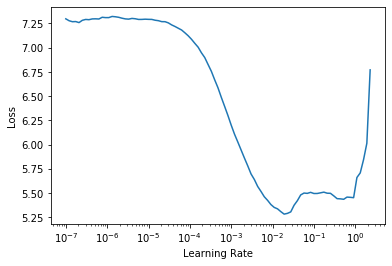

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_max=2e-3)

(#5) [0,4.742748260498047,3.433241605758667,0.13249999284744263,00:17]
(#5) [1,3.5556559562683105,4.990420341491699,0.11249999701976776,00:12]
(#5) [2,3.0659592151641846,3.1462185382843018,0.2150000035762787,00:12]
(#5) [3,2.619236946105957,2.3852078914642334,0.33250001072883606,00:12]
(#5) [4,2.2361373901367188,2.5636541843414307,0.32499998807907104,00:12]
(#5) [5,1.9014582633972168,2.0571610927581787,0.4350000023841858,00:12]
(#5) [6,1.6128405332565308,1.7362765073776245,0.5149999856948853,00:12]
(#5) [7,1.3629419803619385,1.5534389019012451,0.5649999976158142,00:12]
(#5) [8,1.1459509134292603,1.3968102931976318,0.6050000190734863,00:12]
(#5) [9,1.0005580186843872,1.4534624814987183,0.6100000143051147,00:12]


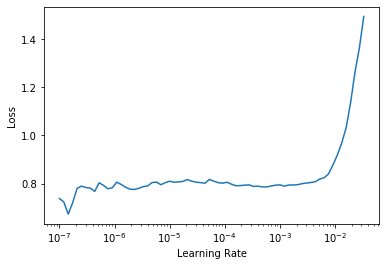

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(8e-4))

(#5) [0,0.7901014089584351,1.502400517463684,0.6050000190734863,00:12]
(#5) [1,0.816780686378479,1.7677453756332397,0.5049999952316284,00:12]
(#5) [2,0.8859437108039856,1.8608779907226562,0.5024999976158142,00:12]
(#5) [3,0.8878102898597717,1.8241270780563354,0.5024999976158142,00:12]
(#5) [4,0.8428448438644409,1.7408032417297363,0.5350000262260437,00:12]
(#5) [5,0.7749873399734497,1.3923873901367188,0.6025000214576721,00:12]
(#5) [6,0.6915755867958069,1.335370659828186,0.6200000047683716,00:12]
(#5) [7,0.6089401841163635,1.2763252258300781,0.6499999761581421,00:12]
(#5) [8,0.5517759323120117,1.223260760307312,0.6700000166893005,00:12]
(#5) [9,0.503037691116333,1.2118808031082153,0.6725000143051147,00:12]


In [ ]:
learn.fit_one_cycle(10, lr_max=2e-3)

(#5) [0,4.611145496368408,4.05537223815918,0.05999999865889549,00:07]
(#5) [1,3.5815956592559814,6.728524208068848,0.09000000357627869,00:06]
(#5) [2,3.0904316902160645,4.964371204376221,0.0949999988079071,00:05]
(#5) [3,2.703627824783325,4.748586177825928,0.12999999523162842,00:05]
(#5) [4,2.3473732471466064,2.2155497074127197,0.4000000059604645,00:06]
(#5) [5,2.0084071159362793,2.1762659549713135,0.4050000011920929,00:06]
(#5) [6,1.7111304998397827,2.0884854793548584,0.4749999940395355,00:06]
(#5) [7,1.4681951999664307,1.5786409378051758,0.574999988079071,00:06]
(#5) [8,1.2606219053268433,1.3570386171340942,0.6200000047683716,00:05]
(#5) [9,1.0988014936447144,1.4073833227157593,0.5975000262260437,00:05]


In [ ]:
learn.fit_one_cycle(10, lr_max=1e-2)

(#5) [0,0.8529038429260254,1.4644263982772827,0.6025000214576721,00:06]
(#5) [1,1.0374728441238403,3.1434755325317383,0.36250001192092896,00:06]
(#5) [2,1.364072322845459,3.325856924057007,0.3149999976158142,00:06]
(#5) [3,1.3460434675216675,2.4823246002197266,0.42250001430511475,00:05]
(#5) [4,1.214269757270813,1.9585118293762207,0.47999998927116394,00:06]
(#5) [5,1.0606365203857422,1.850061297416687,0.5274999737739563,00:06]
(#5) [6,0.9020562171936035,1.343560814857483,0.6100000143051147,00:06]
(#5) [7,0.7671628594398499,1.3671907186508179,0.6225000023841858,00:06]
(#5) [8,0.6507179141044617,1.2855066061019897,0.6449999809265137,00:06]
(#5) [9,0.5612492561340332,1.1975786685943604,0.6575000286102295,00:05]


## Rocket on ESC-50

In [ ]:
class ROCKET(nn.Module):
    def __init__(self, c_in=1, seq_len=1000, n_kernels=10000, kss=[7, 9, 11]):
        '''
        ROCKET is a GPU Pytorch implementation of the ROCKET methods generate_kernels 
        and apply_kernels that can be used  with univariate and multivariate time series.
        Input: is a 3d torch tensor of type torch.float32. When used with univariate TS, 
        make sure you transform the 2d to 3d by adding unsqueeze(1).
        c_in: number of channels or features. For univariate c_in is 1.
        seq_len: sequence length
        '''
        super().__init__()
        kss = [ks for ks in kss if ks < seq_len]
        make_convs = nn.ModuleList()
        for i in range(n_kernels):
            ks = int(np.random.choice(kss))
            dilation = 2**np.random.uniform(0, np.log2((seq_len - 1) // (ks - 1)))
            padding = int((ks - 1) * dilation // 2) if np.random.randint(2) == 1 else 0
            weight = torch.randn(1, c_in, ks)
            weight -= weight.mean()
            bias = 2 * (torch.rand(1) - .5)
            layer = nn.Conv1d(c_in, 1, ks, padding=2 * padding, dilation=int(dilation), bias=True)
            layer.weight = torch.nn.Parameter(weight, requires_grad=False)
            layer.bias = torch.nn.Parameter(bias, requires_grad=False)
            make_convs.append(layer)
        self.convs = make_convs

    def forward(self, x):
        output = []
        for conv in self.convs:
            out = conv(x)
            _max = out.max(dim=-1).values
            _ppv = torch.gt(out, 0).sum(dim=-1).float() / out.shape[-1]
            cat = torch.cat((_max, _ppv), dim=-1)
            output.append(cat)
        output = torch.cat(output, dim=-1)
        return output

In [ ]:
a2s = AudioToSpec(hop_length=512, n_mels=128, n_fft=1024, top_db=80, f_min=20., f_max=22050.)
crop_2000ms = CropSignal(2000)
tfms = [crop_2000ms, a2s]
dbunch = auds.databunch(pESC50, item_tfms=tfms, bs=1600)

In [ ]:
x_train, y_train = dbunch.train_dl.one_batch()
x_valid, y_valid = dbunch.valid_dl.one_batch()
print(y_train.shape, y_valid.shape)

torch.Size([400])


In [ ]:
x_train = x_train.squeeze(1).cuda()
x_valid = x_valid.squeeze(1).cuda()

In [ ]:
mdl_tst = ROCKET(c_in=x_train.shape[1], seq_len=x_train.shape[2], n_kernels=10000)
mdl_tst.cuda();

In [ ]:
import time

t = time.time()
feat = mdl_tst(x_train)
torch.cuda.synchronize()
print(f"{time.time() - t:.5f} seconds to process")

91.41890 seconds to process


In [ ]:
from sklearn.linear_model import RidgeClassifierCV
classifier = RidgeClassifierCV(alphas=np.logspace(-8, 8, 17), normalize=True)

In [ ]:
classifier.fit(feat.cpu(), y_train.cpu());

In [ ]:
feat_valid = mdl_tst(x_valid)

In [ ]:
classifier.score(feat_valid.cpu(), y_valid.cpu())

0.4925

### Attempt with different settings

In [ ]:
a2s = AudioToSpec(hop_length=256, n_mels=128, n_fft=2560, top_db=100, f_min=0., f_max=22050.)
crop_5000ms = CropSignal(5000)
resampler = Resample(8000)
silencer = RemoveSilence()
tfms = [silencer, crop_5000ms, a2s]
dbunch = auds.databunch(pESC50, item_tfms=tfms, bs=1600)

In [ ]:
x_train, y_train = dbunch.train_dl.one_batch()
x_valid, y_valid = dbunch.valid_dl.one_batch()
print(y_train.shape, y_valid.shape)

torch.Size([1600]) torch.Size([400])


In [ ]:
x_train = x_train.squeeze(1).cuda()
x_valid = x_valid.squeeze(1).cuda()

In [ ]:
mdl_tst = ROCKET(c_in=x_train.shape[1], seq_len=x_train.shape[2], n_kernels=1000)
mdl_tst.cuda();

In [ ]:
import time

t = time.time()
feat = mdl_tst(x_train)
torch.cuda.synchronize()
print(f"{time.time() - t:.5f} seconds to process")

114.23677 seconds to process


In [ ]:
from sklearn.linear_model import RidgeClassifierCV
classifier = RidgeClassifierCV(alphas=np.logspace(-8, 8, 17), normalize=True)

In [ ]:
classifier.fit(feat.cpu(), y_train.cpu());

In [ ]:
feat_valid = mdl_tst(x_valid)

In [ ]:
classifier.score(feat_valid.cpu(), y_valid.cpu())

0.5575

## Raw Audio on ESC50

## Training a raw audio model

In [ ]:
class Wav2Letter(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 250,  kernel_size=250, stride=160),
            nn.BatchNorm1d(250),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(250, 250,  kernel_size=48, stride=2),
            nn.BatchNorm1d(250),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(250, 250,  kernel_size=8, stride=1),
            nn.BatchNorm1d(250),
            nn.ReLU(),
        )
        self.conv9 = nn.Sequential(
            nn.Conv1d(250, 2000,  kernel_size=34, stride=1),
            nn.BatchNorm1d(2000),
            nn.ReLU(),
        )
        self.conv10 = nn.Sequential(
            nn.Conv1d(2000, 2000,  kernel_size=1, stride=1),
            nn.BatchNorm1d(2000),
            nn.ReLU(),
        )
    
        self.conv11 = nn.Conv1d(2000,10, kernel_size=1, stride=1)
    def forward(self, t):
        #print("Shape befor conv1", t.shape)
        t = self.conv1(t)
        #print("Shape after conv1", t.shape)
        t = self.conv2(t)
        #print("Shape after conv2", t.shape)
        for i in range(6):
            t = self.conv3(t)
            #print("Shape after conv", i+3, t.shape)
            t = F.relu(t)
        t = self.conv9(t)
        #print("Shape after conv9", t.shape)
        t = F.relu(t)
        t = self.conv10(t)
        #print("Shape after conv10", t.shape)
        t = self.conv11(t).squeeze(-1)
        #print("Shape after conv11", t.shape)
        return t

In [ ]:
class SampleCNN(nn.Module):
    def __init__(self):
        super(SampleCNN, self).__init__()

        # 59049 x 1
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 128, kernel_size=3, stride=3, padding=0),
            nn.BatchNorm1d(128),
            nn.ReLU())
        # 19683 x 128
        self.conv2 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=3))
        # 6561 x 128
        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 2187 x 128
        self.conv4 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 729 x 256
        self.conv5 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 243 x 256
        self.conv6 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3),
            nn.Dropout(0./5))
        # 81 x 256
        self.conv7 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 27 x 256
        self.conv8 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 9 x 256
        self.conv9 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 3 x 256
        self.conv10 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 1 x 512 
        self.conv11 = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5))
        # 1 x 512 
        self.fc1 = nn.Linear(512, 200)
        self.fc2 = nn.Linear(200,50)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        # input x : 23 x 59049 x 1
        # expected conv1d input : minibatch_size x num_channel x width

        x = x.view(x.shape[0], 1,-1)
        # x : 23 x 1 x 59049
        #print(x.shape)
        out = self.conv1(x)
        #print(out.shape)
        out = self.conv2(out)
        #print(out.shape)
        out = self.conv3(out)
        #print(out.shape)
        out = self.conv4(out)
        #print(out.shape)
        out = self.conv5(out)
        #print(out.shape)
        out = self.conv6(out)
        #print(out.shape)
        out = self.conv7(out)
        #print(out.shape)
        out = self.conv8(out)
        #print(out.shape)
        out = self.conv9(out)
        #print(out.shape)
        out = self.conv10(out)
        #print(out.shape)
        out = self.conv11(out) 
        #print(out.shape)
        out = out.view(x.shape[0], out.size(1) * out.size(2))
        out = self.fc1(out)
        #print(out.shape)
        out = self.fc2(out)
        #print(out.shape)
        return out
        
        #logit = self.fc(out)

        #logit = self.activation(logit)

        #return logit

In [ ]:
oa_esc50 = OpenAudio(files_ESC50)

In [ ]:
esc_labeler = lambda x: DF[DF["filename"] == str(x).split('/')[-1]]["category"].values[0]
auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=split_fold_5,
                 get_y=esc_labeler)

In [ ]:
def GetSig():
    def _inner(ai:AudioItem)->AudioItem:
        return ai.sig
    return _inner

In [ ]:
crop_3700ms = CropSignal(3700)
resampler = Resample(16000)
tfms = [resampler, crop_3700ms, GetSig()]
dbunch = auds.databunch(pESC50, item_tfms=tfms, bs=48)

In [ ]:
dbunch.one_batch()[0].shape

torch.Size([48, 1, 59200])

In [ ]:
model_cnn = SampleCNN().cuda()

In [ ]:
learn = Learner(dbunch, 
                model_cnn,
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
#nchannels = dbunch.one_batch()[0].shape[1]
#alter_learner(learn, nchannels)

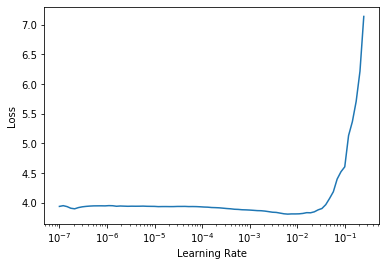

In [ ]:
learn.lr_find()

In [ ]:
learn.fit(10, lr=1e-2)

(#5) [0,5.045242786407471,4.030633449554443,0.02250000089406967,00:17]
(#5) [1,4.91574239730835,4.1141228675842285,0.027499999850988388,00:16]
(#5) [2,4.561268329620361,3.971543550491333,0.032499998807907104,00:16]
(#5) [3,4.3696064949035645,9.048896789550781,0.017500000074505806,00:16]
(#5) [4,4.161566734313965,3.7582614421844482,0.042500000447034836,00:16]
(#5) [5,3.898627996444702,4.057292938232422,0.05249999836087227,00:16]
(#5) [6,3.7431344985961914,3.4990482330322266,0.08250000327825546,00:16]
(#5) [7,3.5861778259277344,3.3607282638549805,0.05999999865889549,00:16]
(#5) [8,3.4843759536743164,3.991708755493164,0.09000000357627869,00:16]
(#5) [9,3.384648323059082,3.8111963272094727,0.0949999988079071,00:16]


In [ ]:
learn.fit(10, lr=5e-3)

(#5) [0,3.143995523452759,3.5211966037750244,0.125,00:16]
(#5) [1,3.0991389751434326,3.279263973236084,0.10999999940395355,00:16]
(#5) [2,3.0614304542541504,3.1434237957000732,0.13750000298023224,00:16]
(#5) [3,3.0367743968963623,3.110544204711914,0.13249999284744263,00:16]
(#5) [4,2.9900922775268555,3.9071059226989746,0.11999999731779099,00:16]
(#5) [5,2.938640594482422,3.1118788719177246,0.14249999821186066,00:16]
(#5) [6,2.911473512649536,3.0811212062835693,0.17249999940395355,00:16]
(#5) [7,2.875178575515747,3.087613105773926,0.15000000596046448,00:16]
(#5) [8,2.8650314807891846,2.923142671585083,0.18000000715255737,00:16]
(#5) [9,2.8121325969696045,3.0159571170806885,0.18250000476837158,00:16]


In [ ]:
learn.fit(50, lr=5e-3)

(#5) [0,2.70332670211792,3.1430068016052246,0.2224999964237213,00:16]
(#5) [1,2.728884696960449,2.919307231903076,0.20250000059604645,00:16]
(#5) [2,2.703312873840332,2.925222158432007,0.19249999523162842,00:16]
(#5) [3,2.6629347801208496,3.3038580417633057,0.12999999523162842,00:16]
(#5) [4,2.644568920135498,2.822532892227173,0.20250000059604645,00:16]
(#5) [5,2.615952253341675,2.7506661415100098,0.25,00:16]
(#5) [6,2.6225991249084473,2.9884305000305176,0.18000000715255737,00:16]
(#5) [7,2.614938497543335,3.0330255031585693,0.17249999940395355,00:16]
(#5) [8,2.5629096031188965,2.6613845825195312,0.25999999046325684,00:16]
(#5) [9,2.4885051250457764,2.6975371837615967,0.2574999928474426,00:16]
(#5) [10,2.4370086193084717,2.8612585067749023,0.2775000035762787,00:16]
(#5) [11,2.384814500808716,3.6821365356445312,0.2175000011920929,00:16]
(#5) [12,2.3633885383605957,2.5217320919036865,0.30250000953674316,00:16]
(#5) [13,2.3145856857299805,2.655489444732666,0.30000001192092896,00:16]
(#5) 

## Not training well, let's try 250 speaker and see if voice rec is different

In [ ]:
get_250speakers_label = lambda x: str(x).split('/')[-3][3:]

In [ ]:
def GetSig():
    def _inner(ai:AudioItem)->AudioItem:
        return ai.sig
    return _inner

In [ ]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 get_y=get_250speakers_label)

dbunch250 = auds.databunch(p250speakers, item_tfms=tfms, bs=64)

NameError: name 'tfms' is not defined

In [ ]:
crop_3700ms = CropSignal(3700)
tfms = [crop_3700ms, GetSig()]
dbunch = auds.databunch(p250speakers, item_tfms=tfms, bs=64)

In [ ]:
class SampleCNN(nn.Module):
    def __init__(self):
        super(SampleCNN, self).__init__()

        # 59049 x 1
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 128, kernel_size=3, stride=3, padding=0),
            nn.BatchNorm1d(128),
            nn.ReLU())
        # 19683 x 128
        self.conv2 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=3))
        # 6561 x 128
        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 2187 x 128
        self.conv4 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 729 x 256
        self.conv5 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 243 x 256
        self.conv6 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3),
            nn.Dropout(0.5))
        # 81 x 256
        self.conv7 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 27 x 256
        self.conv8 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 9 x 256
        self.conv9 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 3 x 256
        self.conv10 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 1 x 512 
        self.conv11 = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5))
        # 1 x 512 
        self.fc1 = nn.Linear(512, 375)
        self.fc2 = nn.Linear(375,250)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        # input x : 23 x 59049 x 1
        # expected conv1d input : minibatch_size x num_channel x width

        x = x.view(x.shape[0], 1,-1)
        # x : 23 x 1 x 59049
        #print(x.shape)
        out = self.conv1(x)
        #print(out.shape)
        out = self.conv2(out)
        #print(out.shape)
        out = self.conv3(out)
        #print(out.shape)
        out = self.conv4(out)
        #print(out.shape)
        out = self.conv5(out)
        #print(out.shape)
        out = self.conv6(out)
        #print(out.shape)
        out = self.conv7(out)
        #print(out.shape)
        out = self.conv8(out)
        #print(out.shape)
        out = self.conv9(out)
        #print(out.shape)
        out = self.conv10(out)
        #print(out.shape)
        out = self.conv11(out) 
        #print(out.shape)
        out = out.view(x.shape[0], out.size(1) * out.size(2))
        out = self.fc1(out)
        #print(out.shape)
        out = self.fc2(out)
        #print(out.shape)
        return out
        
        #logit = self.fc(out)

        #logit = self.activation(logit)

        #return logit

In [ ]:
model_cnn = SampleCNN().cuda()

In [ ]:
learn = Learner(dbunch, 
                model_cnn,
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])

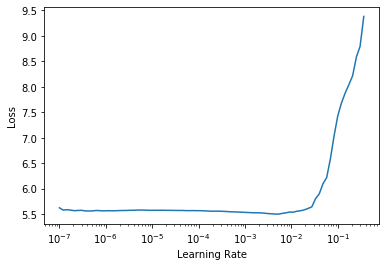

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, lr_max=3e-3)

(#5) [0,4.096113204956055,4.302222728729248,0.11028999835252762,05:21]
(#5) [1,3.5255556106567383,5.323293685913086,0.09248684346675873,05:07]
(#5) [2,3.2658090591430664,3.8444199562072754,0.2025528997182846,05:07]
(#5) [3,2.946685552597046,2.9944841861724854,0.31116336584091187,05:07]
(#5) [4,2.6352133750915527,2.954530715942383,0.32213637232780457,05:07]
(#5) [5,2.3154265880584717,3.090120792388916,0.3253834843635559,05:08]
(#5) [6,2.048099994659424,2.7285561561584473,0.3802485764026642,05:08]
(#5) [7,1.8495780229568481,2.066857099533081,0.49188220500946045,05:08]
(#5) [8,1.704954981803894,2.4404079914093018,0.42615607380867004,05:08]
(#5) [9,1.536723256111145,1.977567434310913,0.5245773196220398,05:08]
(#5) [10,1.3741086721420288,1.538467526435852,0.6135931015014648,05:08]
(#5) [11,1.2290085554122925,1.1873090267181396,0.6909640431404114,05:08]
(#5) [12,1.1116015911102295,1.2263519763946533,0.6827902793884277,05:08]
(#5) [13,0.9621904492378235,0.9647887349128723,0.7442615628242493,0

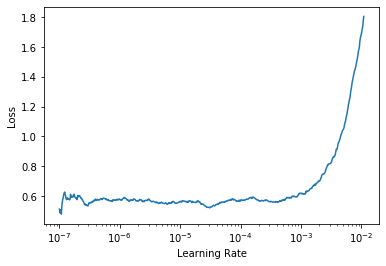

In [ ]:
learn.lr_find(num_it=1000)

In [ ]:
learn.fit_one_cycle(20, lr_max=slice(1e-4, 6e-4))

(#5) [0,0.59647136926651,0.6093095541000366,0.8402194380760193,05:04]
(#5) [1,0.597713828086853,0.626058042049408,0.836188554763794,05:09]
(#5) [2,0.6490824222564697,0.713577926158905,0.814802348613739,05:09]
(#5) [3,0.6792464256286621,0.7048753499984741,0.8190572261810303,05:09]
(#5) [4,0.6484290957450867,0.7089768648147583,0.8161460161209106,05:08]
(#5) [5,0.6500468254089355,0.7232731580734253,0.8137946724891663,05:08]
(#5) [6,0.6184006333351135,0.7272301912307739,0.811219334602356,05:08]
(#5) [7,0.5734274387359619,0.7655994892120361,0.8052849769592285,05:08]
(#5) [8,0.5747023820877075,0.6374108791351318,0.8374202251434326,05:08]
(#5) [9,0.5262126922607422,0.640002965927124,0.8370842933654785,05:08]
(#5) [10,0.5170871019363403,0.6218546032905579,0.8377561569213867,05:08]
(#5) [11,0.47292575240135193,0.5680103302001953,0.8525360822677612,05:08]
(#5) [12,0.44977763295173645,0.5537486672401428,0.8628373146057129,05:08]
(#5) [13,0.45351362228393555,0.5307588577270508,0.8656365275382996,0

# PyTorch VGGish

In [ ]:
! pip install -i https://test.pypi.org/simple/ torchvggish==0.1

Looking in indexes: https://test.pypi.org/simple/
  Using cached https://test-files.pythonhosted.org/packages/ca/0a/fac547eec9a203b2abb6c5f92b9fd3f9c22afcd76748459e8ec70044747a/torchvggish-0.1-py3-none-any.whl


In [ ]:
from torchvggish import vggish, vggish_input

In [ ]:
# Initialise model and download weights
embedding_model = vggish()
embedding_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
path_example = "/home/jupyter/rob/pytorch_videos/RNN-walkthrough/audio_sample/album.wav"

In [ ]:
def get_embedding(p):
    example = vggish_input.wavfile_to_examples(p)
    embedding = embedding_model.forward(example)
    return embedding

In [ ]:
def get_embedding_batch(paths):
    pass

In [ ]:
import time
start = time.time()
embeddings = []
for i,f in enumerate(files_ESC50):
    if(i%50 == 0): print(f"{i}, {time.time()-start:2f}")
    embeddings.append(get_embedding(f))

0, 0.002336
50, 10.680069
100, 21.591210
150, 32.420957
200, 43.952048
250, 55.101673
300, 65.923700
350, 77.289709
400, 88.509248
450, 99.999045
500, 111.301508
550, 122.671296
600, 133.873600
650, 145.175162
700, 156.302858
750, 167.826710
800, 179.985438
850, 192.763642
900, 205.726375
950, 218.558569
1000, 231.244728
1050, 243.504877
1100, 255.982737
1150, 268.604558
1200, 281.116046
1250, 293.752684
1300, 306.190345
1350, 318.429255
1400, 330.226478
1450, 341.726424


In [ ]:
embedding.shape

torch.Size([5, 128])

In [ ]:
embeddings = embedding_model.forward(example)

In [ ]:
files_ESC50

(#2000) [/home/jupyter/.fastai/data/ESC-50/ESC-50-master/audio/1-60676-A-34.wav,/home/jupyter/.fastai/data/ESC-50/ESC-50-master/audio/5-179865-A-43.wav,/home/jupyter/.fastai/data/ESC-50/ESC-50-master/audio/2-117271-A-0.wav,/home/jupyter/.fastai/data/ESC-50/ESC-50-master/audio/1-155858-B-25.wav,/home/jupyter/.fastai/data/ESC-50/ESC-50-master/audio/4-173865-B-9.wav,/home/jupyter/.fastai/data/ESC-50/ESC-50-master/audio/2-104877-A-3.wav,/home/jupyter/.fastai/data/ESC-50/ESC-50-master/audio/1-11687-A-47.wav,/home/jupyter/.fastai/data/ESC-50/ESC-50-master/audio/4-144083-B-16.wav,/home/jupyter/.fastai/data/ESC-50/ESC-50-master/audio/5-238492-A-23.wav,/home/jupyter/.fastai/data/ESC-50/ESC-50-master/audio/1-43760-A-11.wav...]

In [ ]:
embeddings.shape

torch.Size([128])

In [ ]:
oa_esc50 = OpenAudio(files_ESC50)

In [ ]:
sig, _, file = oa_esc50(0)

In [ ]:
sig.shape

torch.Size([1, 220500])

In [ ]:
sig, _, file = oa_esc50(1)

In [ ]:
sig.shape

torch.Size([1, 220500])

In [ ]:
files_10= x(p10speakers)

In [ ]:
oa10 = OpenAudio(files_10)

In [ ]:
sig, _, file = oa10(6)

In [ ]:
sig.shape

torch.Size([1, 46720])

In [ ]:
file

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00282.wav')

In [ ]:
import torchvggish